In [36]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from collections import defaultdict
import random
import time
from scipy.stats import t
import math

In [2]:
# Data preprocessing
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())
train_data = trainset.data
train_labels = trainset.targets
train_data = train_data.view([len(train_data), 28*28])
train_data = train_data / 255.0
test_data = testset.data
test_labels = testset.targets
test_data = testset.data.view([len(test_data), 28*28])
test_data = test_data / 255.0
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [3]:
def kNNclassifier(xTrain, yTrain, xTest=test_data, yTest=test_labels):
  model = KNeighborsClassifier(n_neighbors=1)
  model.fit(xTrain, yTrain)
  accuracy = model.score(xTest, yTest)

  return accuracy

In [4]:
def baselineMethod(xTrain, yTrain, M):
  indices = np.random.randint(0, xTrain.shape[0], size=M)

  return indices

In [5]:
def kMeansPrototype(xTrain, yTrain, M):
  indices = []
  classes = np.unique(yTrain)
  num_clusters = int(M / len(classes))
  x_indices = defaultdict(list)
  for index in range(len(yTrain)):
    x_indices[yTrain[index]].append(index)
  for label in x_indices.keys():
    centroids = KMeans(n_clusters=num_clusters).fit(xTrain[x_indices[label]]).cluster_centers_
    prototype_indices, _ = pairwise_distances_argmin_min(centroids, xTrain[x_indices[label]])
    for i in range(num_clusters):
      prototype_indices[i] = x_indices[label][prototype_indices[i]]
    indices.append(prototype_indices)
  indices = np.concatenate(indices).ravel()

  return indices

In [6]:
def EditedNN(xTrain, yTrain, M):
  indices = []
  x_index = np.random.permutation(len(yTrain))
  for index in x_index:
    if len(indices) >= M:
      return indices
    dist = np.linalg.norm(xTrain - xTrain[index], ord=2, axis=1)
    nn = np.argsort(dist, axis=0)[1]
    if yTrain[nn] == yTrain[index]:
      indices.append(index)

  return indices

In [7]:
def CNN(xTrain, yTrain, M):
  indices = []
  grabbag = []
  x_index = np.random.permutation(len(yTrain))
  indices.append(x_index[0])
  for index in range(1, len(x_index)):
    if len(indices) >= M:
      return indices
    dist = np.linalg.norm(xTrain[indices] - xTrain[index], ord=2, axis=1)
    nn = np.argsort(dist, axis=0)[0]
    if yTrain[nn] != yTrain[index]:
      indices.append(index)
    else:
      grabbag.append(index)

  for index in grabbag:
    if len(indices) >= M:
      return indices
    dist = np.linalg.norm(xTrain[indices] - xTrain[index], ord=2, axis=1)
    nn = np.argsort(dist, axis=0)[0]
    if yTrain[nn] != yTrain[index]:
      indices.append(index)

  return indices

In [8]:
def run():
  iters = 5
  subset_size = [500, 1000, 2000, 5000, 10000]
  models = ['baseline', 'kmeans', 'enn', 'cnn']
  err = np.zeros((5, 4, 5))
  runtime = np.zeros((5, 4, 5))
  for M_index, M in enumerate(subset_size):
    for model_index, model in enumerate(models):
      if model == 'kmeans':
        start = time.time()
        proto_indices = kMeansPrototype(train_data, train_labels, M)
        end = time.time()
        runtime[M_index][model_index][:] = end - start
        acc = kNNclassifier(train_data[proto_indices], train_labels[proto_indices])
        err[M_index][model_index][:] = 1 - acc
      else:
        for iter in range(iters):
          start = time.time()
          if model == 'baseline':
            proto_indices = baselineMethod(train_data, train_labels, M)
          elif model == 'enn':
            proto_indices = EditedNN(train_data, train_labels, M)
          elif model == 'cnn':
            proto_indices = CNN(train_data, train_labels, M)
          end = time.time()
          runtime[M_index][model_index][iter] = end - start
          acc = kNNclassifier(train_data[proto_indices], train_labels[proto_indices])
          err[M_index][model_index][iter] = 1 - acc
  np.save('error.npy', err)
  np.save('runtime.npy', runtime)
  return err, runtime

In [9]:
run()

C:\Users\Muriate_C\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Muriate_C\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Muriate_C\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Muriate_C\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

C:\Users\Muriate_C\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Muriate_C\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Muriate_C\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Muriate_C\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

(array([[[0.1595, 0.1353, 0.154 , 0.1493, 0.1716],
         [0.0863, 0.0863, 0.0863, 0.0863, 0.0863],
         [0.1501, 0.1403, 0.1488, 0.1525, 0.1502],
         [0.1651, 0.1666, 0.1657, 0.167 , 0.1643]],
 
        [[0.114 , 0.1151, 0.1088, 0.1177, 0.1132],
         [0.0724, 0.0724, 0.0724, 0.0724, 0.0724],
         [0.1095, 0.1072, 0.1176, 0.1079, 0.111 ],
         [0.1251, 0.125 , 0.1291, 0.1265, 0.1255]],
 
        [[0.0884, 0.0901, 0.0882, 0.0927, 0.0879],
         [0.0643, 0.0643, 0.0643, 0.0643, 0.0643],
         [0.0874, 0.083 , 0.0888, 0.0855, 0.087 ],
         [0.093 , 0.091 , 0.0893, 0.0947, 0.0919]],
 
        [[0.0669, 0.0672, 0.0672, 0.0717, 0.0643],
         [0.0509, 0.0509, 0.0509, 0.0509, 0.0509],
         [0.0671, 0.0658, 0.0613, 0.0652, 0.0659],
         [0.0679, 0.0679, 0.0679, 0.0653, 0.0661]],
 
        [[0.053 , 0.0507, 0.0536, 0.0511, 0.0532],
         [0.0443, 0.0443, 0.0443, 0.0443, 0.0443],
         [0.051 , 0.0486, 0.0508, 0.0524, 0.0519],
         [0.0531, 0

In [12]:
err = np.load('error.npy')
runtime = np.load('runtime.npy')
err_avg, runtime_avg = np.mean(err, axis=2), np.mean(runtime, axis=2)
err_avg, runtime_avg

(array([[0.15394, 0.0863 , 0.14838, 0.16574],
        [0.11376, 0.0724 , 0.11064, 0.12624],
        [0.08946, 0.0643 , 0.08634, 0.09198],
        [0.06746, 0.0509 , 0.06506, 0.06702],
        [0.05232, 0.0443 , 0.05094, 0.05362]]),
 array([[0.00000000e+00, 1.49568158e+02, 9.77819602e+01, 3.89502430e-01],
        [0.00000000e+00, 2.52976594e+02, 1.93612186e+02, 2.09773755e+00],
        [1.99270248e-04, 4.85420623e+02, 3.94287601e+02, 9.12717113e+00],
        [0.00000000e+00, 1.15862122e+03, 1.01106121e+03, 6.65758853e+01],
        [2.01416016e-04, 2.37312594e+03, 1.90511121e+03, 2.29231033e+02]]))

In [20]:
M = [500, 1000, 2000, 5000, 10000]
err_b = np.take(err_avg, 0, axis=1)
err_k = np.take(err_avg, 1, axis=1)
err_e = np.take(err_avg, 2, axis=1)
err_c = np.take(err_avg, 3, axis=1)
err_b, err_k, err_e, err_c

(array([0.15394, 0.11376, 0.08946, 0.06746, 0.05232]),
 array([0.0863, 0.0724, 0.0643, 0.0509, 0.0443]),
 array([0.14838, 0.11064, 0.08634, 0.06506, 0.05094]),
 array([0.16574, 0.12624, 0.09198, 0.06702, 0.05362]))

Text(0, 0.5, 'Avg Error Rate')

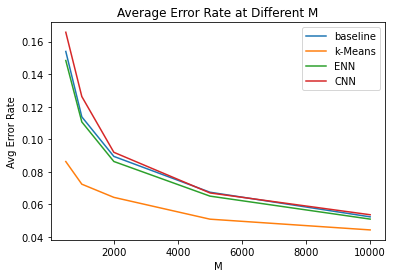

In [25]:
plt.title('Average Error Rate at Different M')
plt.plot(M, err_b, label='baseline')
plt.plot(M, err_k, label='k-Means')
plt.plot(M, err_e, label='ENN')
plt.plot(M, err_c, label='CNN')
plt.legend()
plt.xlabel('M')
plt.ylabel('Avg Error Rate')

In [26]:
rt_b = np.take(runtime_avg, 0, axis=1)
rt_k = np.take(runtime_avg, 1, axis=1)
rt_e = np.take(runtime_avg, 2, axis=1)
rt_c = np.take(runtime_avg, 3, axis=1)
rt_b, rt_k, rt_e, rt_c

(array([0.        , 0.        , 0.00019927, 0.        , 0.00020142]),
 array([ 149.56815791,  252.97659421,  485.4206233 , 1158.62122011,
        2373.12593985]),
 array([  97.7819602 ,  193.61218629,  394.28760066, 1011.06121492,
        1905.11121449]),
 array([  0.38950243,   2.09773755,   9.12717113,  66.5758853 ,
        229.2310329 ]))

Text(0, 0.5, 'Avg Runtime (s)')

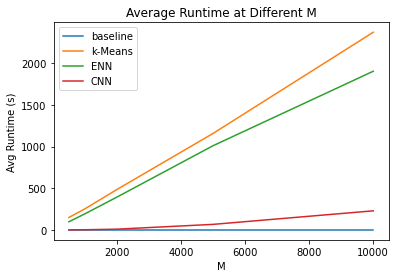

In [29]:
plt.title('Average Runtime at Different M')
plt.plot(M, rt_b, label='baseline')
plt.plot(M, rt_k, label='k-Means')
plt.plot(M, rt_e, label='ENN')
plt.plot(M, rt_c, label='CNN')
plt.legend()
plt.xlabel('M')
plt.ylabel('Avg Runtime (s)')

In [38]:
df = 5 - 1
t_value = t.ppf((1+0.95)/2, df)
np.std(err, axis=2)
err_avg-t_value/math.sqrt(5)*np.std(err, axis=2), err_avg+t_value/math.sqrt(5)*np.std(err, axis=2)

(array([[0.13912541, 0.0863    , 0.14315001, 0.1645219 ],
        [0.11014883, 0.0724    , 0.10602034, 0.12434615],
        [0.08723524, 0.0643    , 0.08388967, 0.0897184 ],
        [0.06450015, 0.0509    , 0.06260339, 0.06564539],
        [0.0508521 , 0.0443    , 0.04931612, 0.05289005]]),
 array([[0.16875459, 0.0863    , 0.15360999, 0.1669581 ],
        [0.11737117, 0.0724    , 0.11525966, 0.12813385],
        [0.09168476, 0.0643    , 0.08879033, 0.0942416 ],
        [0.07041985, 0.0509    , 0.06751661, 0.06839461],
        [0.0537879 , 0.0443    , 0.05256388, 0.05434995]]))